In [80]:
import tensorflow as tf
import numpy as np
import tqdm
import itertools
from matplotlib import pyplot as plt

-1.0 1.0


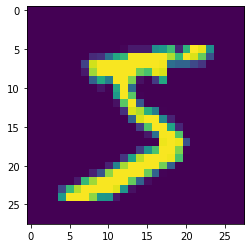

In [12]:
data = tf.keras.datasets.mnist.load_data()
(train_images, _), _ = data
train_images = (train_images - np.float32(127.5)) / np.float32(127.5)
print(train_images.min(), train_images.max())
plt.imshow(train_images[0])

In [18]:
BUFFER_SIZE, BATCH_SIZE = 60_000, 256
dataset = tf.data.Dataset.from_tensor_slices(train_images)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
next(iter(dataset.take(1))).shape

TensorShape([256, 28, 28])

In [39]:
NOISE_DIM = 100
L = tf.keras.layers
generator = tf.keras.Sequential([
    L.Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM, )),
    L.BatchNormalization(),
    L.LeakyReLU(),
    L.Reshape((7, 7, 256)),
    L.Conv2DTranspose(128, (5, 5), strides=(1, 1),
                      padding='same', use_bias=False),
    L.BatchNormalization(),
    L.LeakyReLU(),
    L.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                      padding='same', use_bias=False),
    L.BatchNormalization(),
    L.LeakyReLU(),
    L.Conv2DTranspose(1, (5, 5), strides=(2, 2),
                                padding='same', use_bias=False,
                                activation='tanh'),
])
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_12 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 128)        

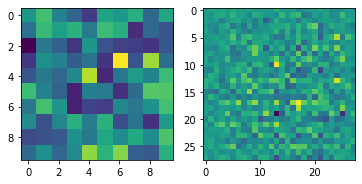

In [40]:
noise = tf.random.normal((1, NOISE_DIM, ))
result = generator(noise)
plt.subplot(1, 2, 1)
plt.imshow(tf.reshape(noise, (10, 10)))
plt.subplot(1, 2, 2)
plt.imshow(tf.reshape(result, (28, 28)))

In [33]:
L = tf.keras.layers
discriminator = tf.keras.Sequential([
    L.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
             input_shape=[28, 28, 1]),
    L.LeakyReLU(),
    L.Dropout(0.3),
    L.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    L.LeakyReLU(),
    L.Dropout(0.3),
    L.Flatten(),
    L.Dense(1),
])
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

tf.Tensor([[-0.02352382]], shape=(1, 1), dtype=float32)


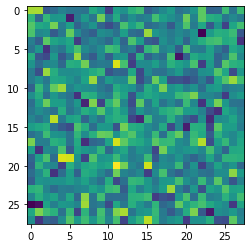

In [35]:
image = tf.random.normal((1, 28, 28, 1))
result = discriminator(image)
result.shape
plt.imshow(tf.reshape(image, (28, 28)))
print(result)

In [37]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
true = np.array([1.])
pred = np.array([.8])
loss(true, pred)

<tf.Tensor: id=3141, shape=(), dtype=float64, numpy=0.37110066413879395>

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [93]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal((BATCH_SIZE, NOISE_DIM))
    real_images = tf.reshape(real_images, (-1, 28, 28, 1))
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        generated_output = discriminator(generated_images, training=True)

        generator_loss = loss(tf.ones_like(generated_output), generated_output)
        discriminator_loss = (loss(tf.ones_like(real_output), real_output) +
                              loss(tf.zeros_like(generated_output), generated_output))

    generator_gradient = generator_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_gradient = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))

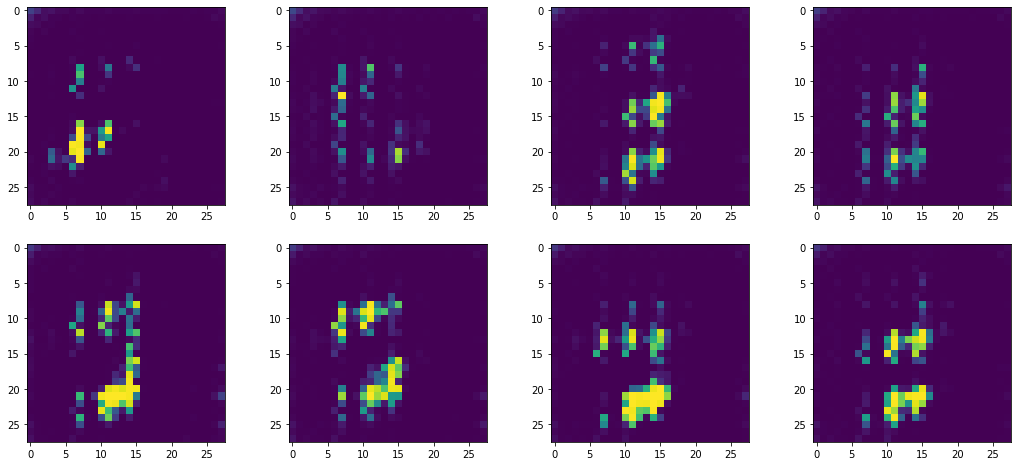

In [94]:
def play(sample_noise):
    result = generator(sample_noise)
    result = tf.reshape(result, (8, 28, 28))
    c = itertools.count(1)
    plt.figure(figsize=(18, 8))
    for image in result:
        plt.subplot(2, 4, next(c))
        plt.imshow(image)
    plt.show()
play(tf.random.normal((8, NOISE_DIM)))

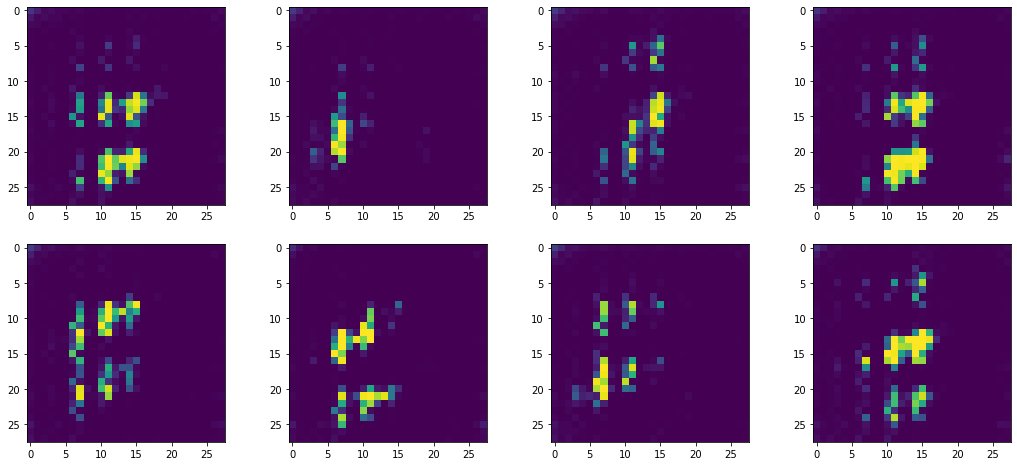

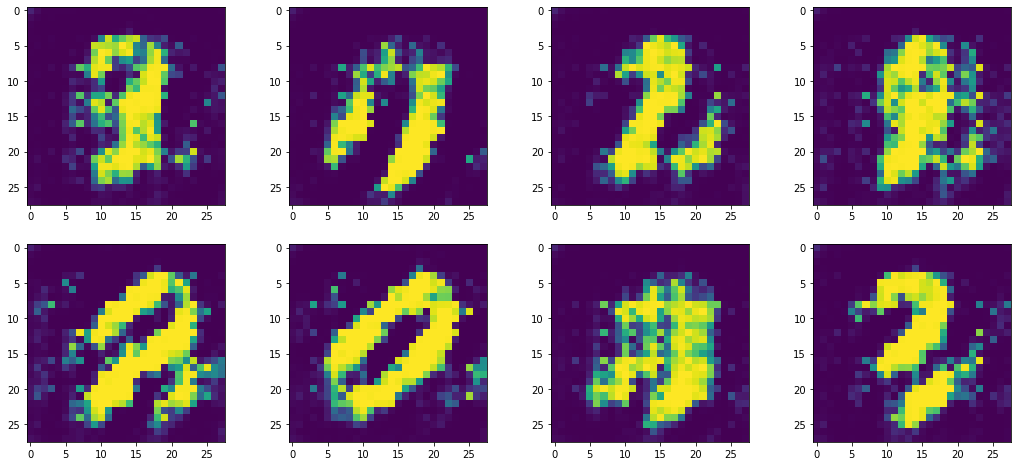

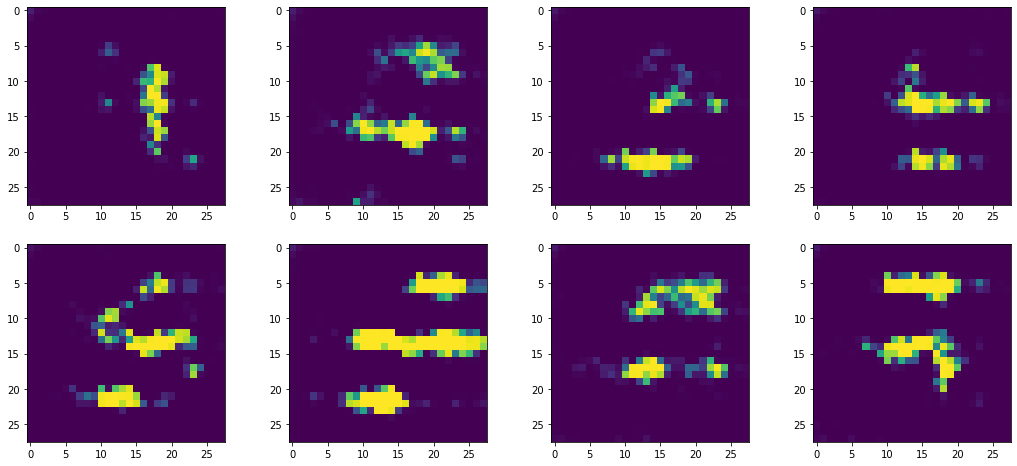

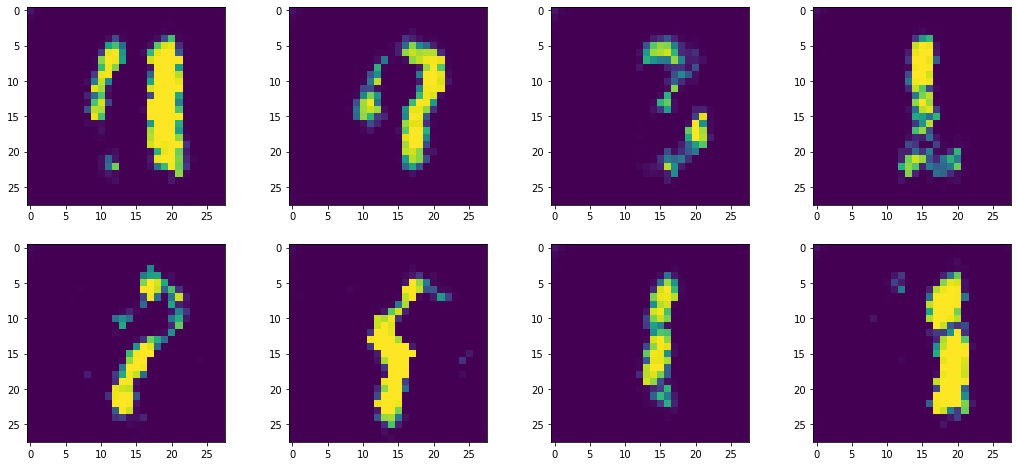

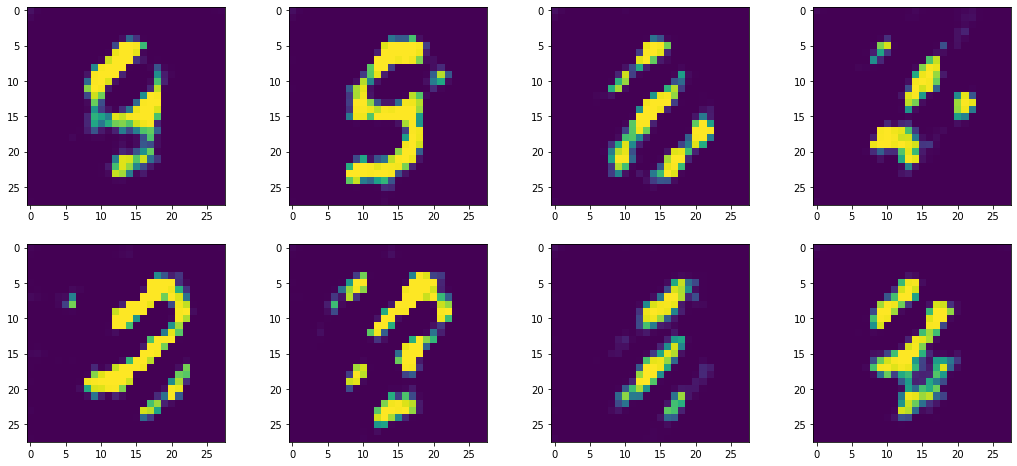

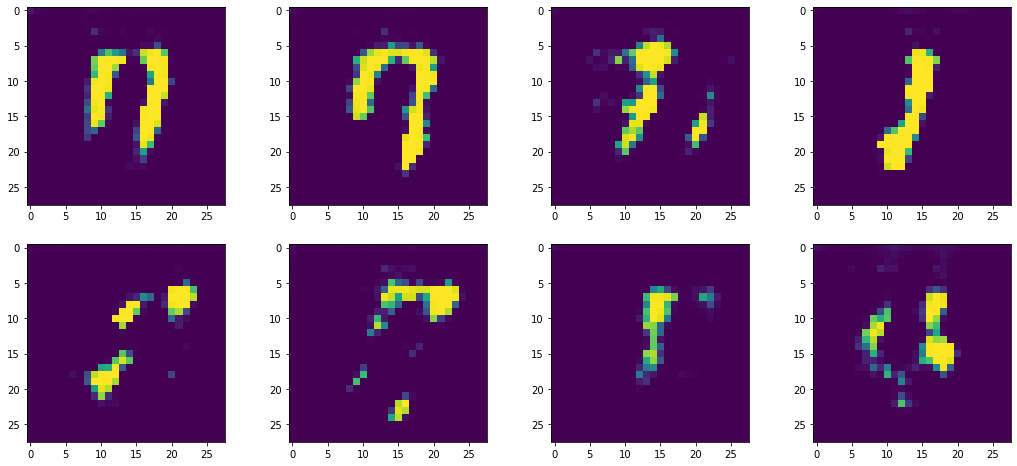

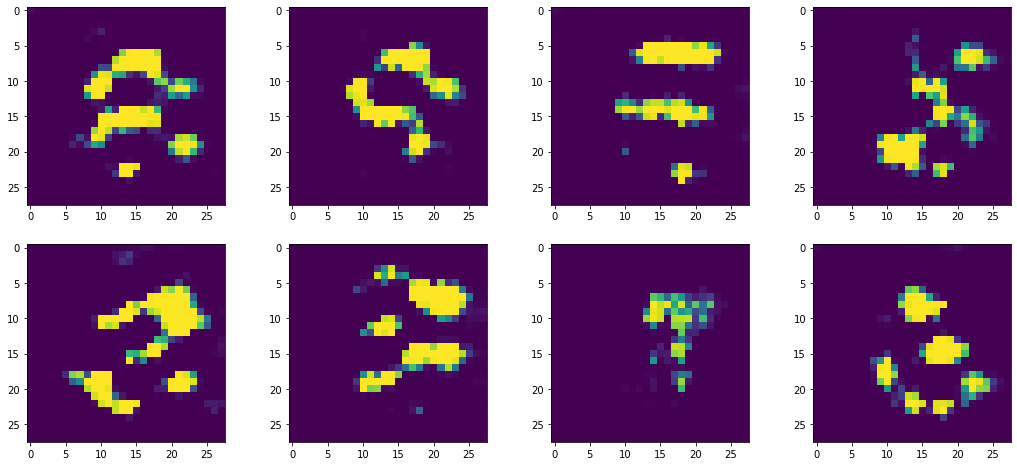

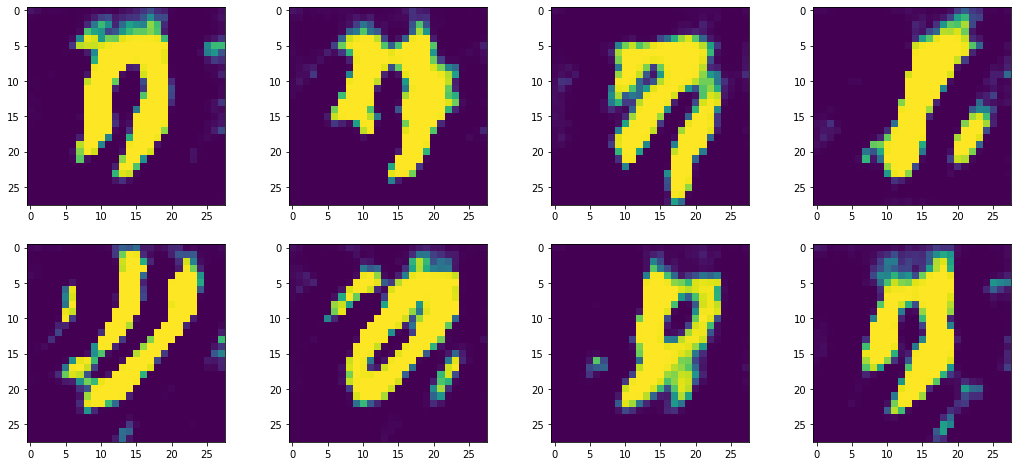

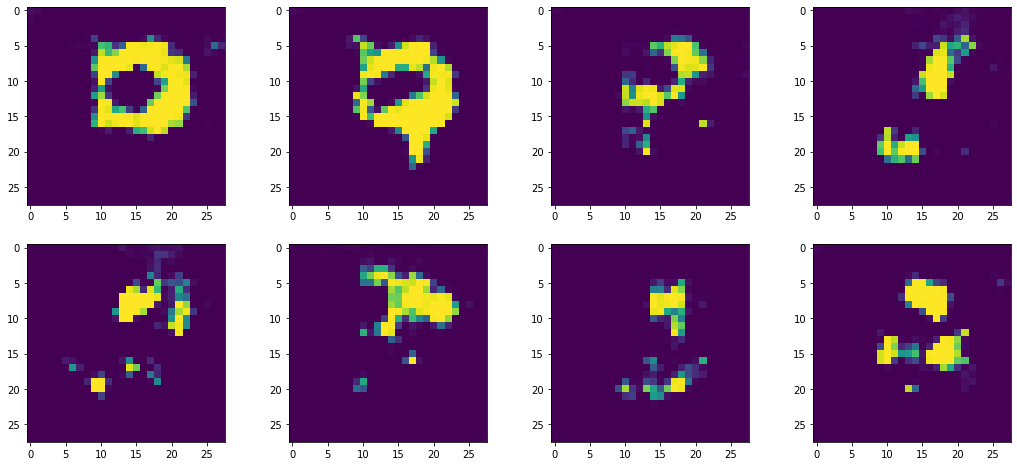

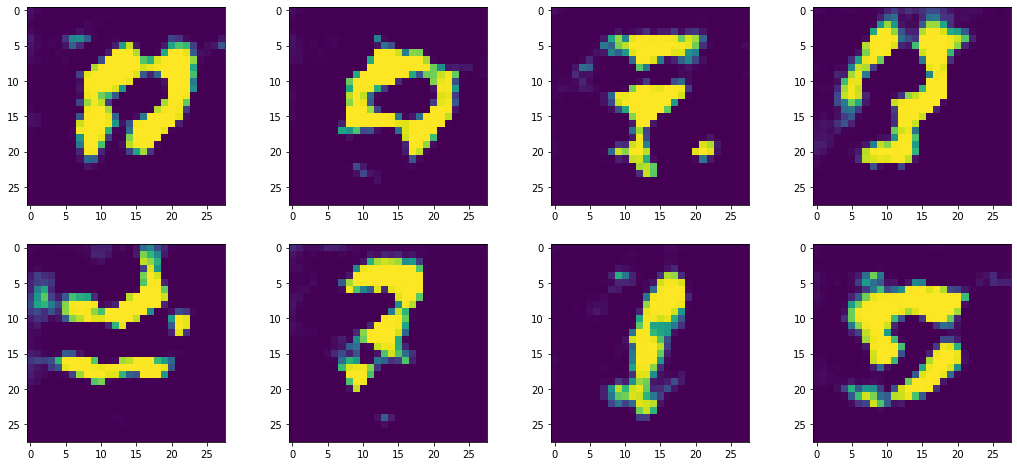

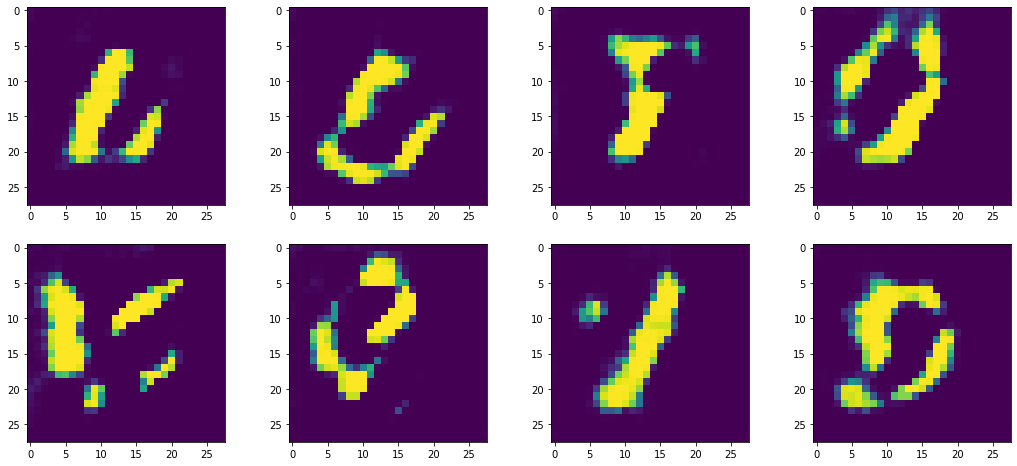

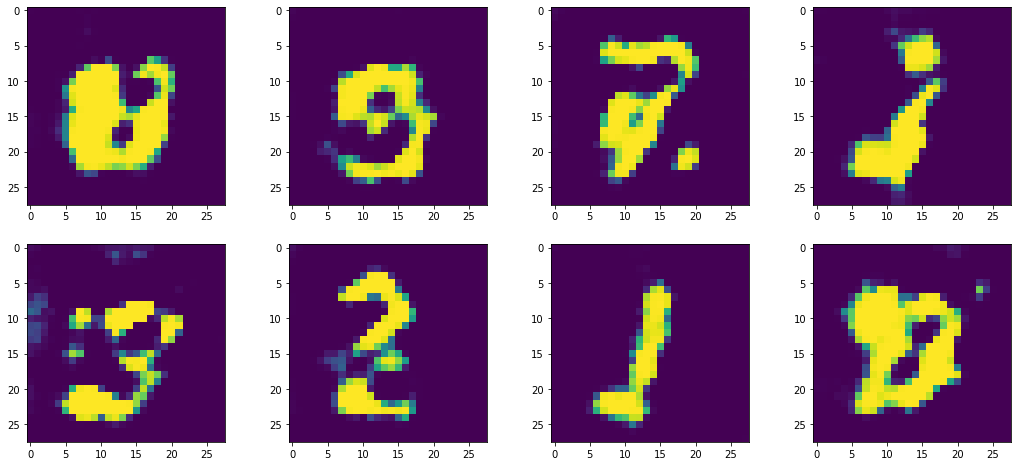

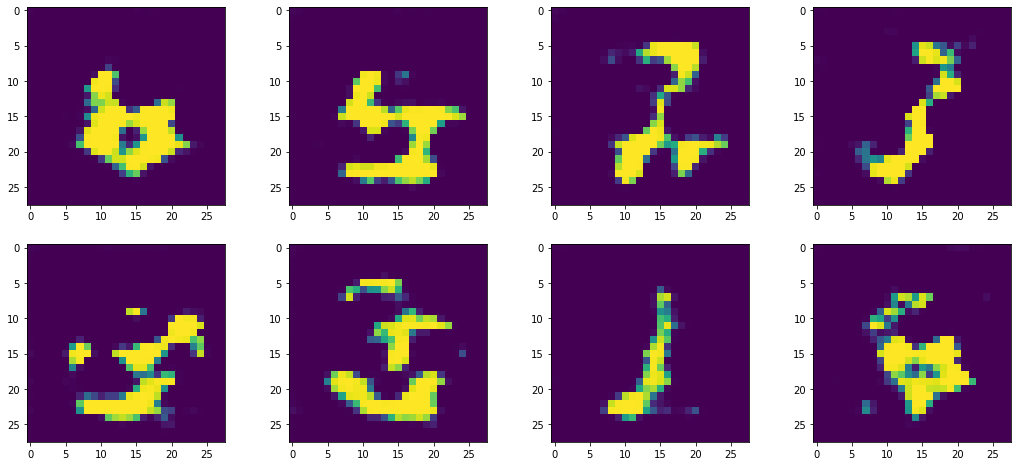

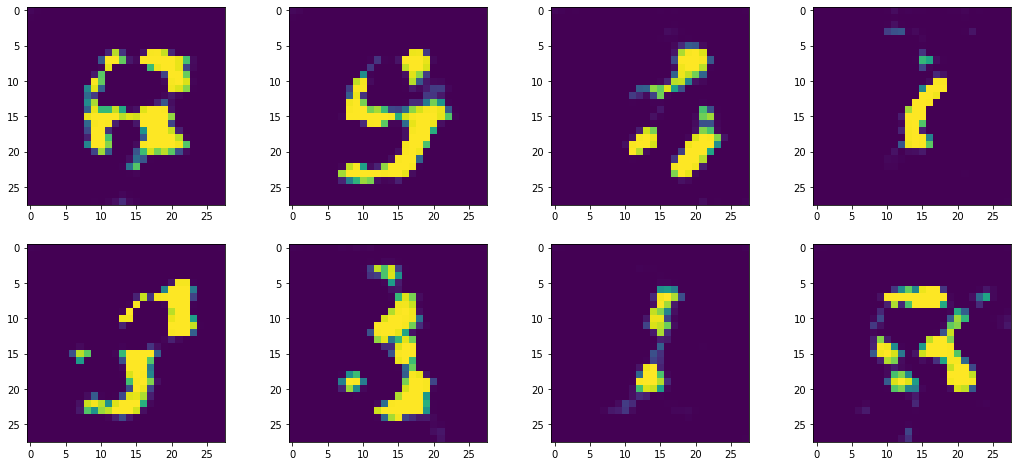

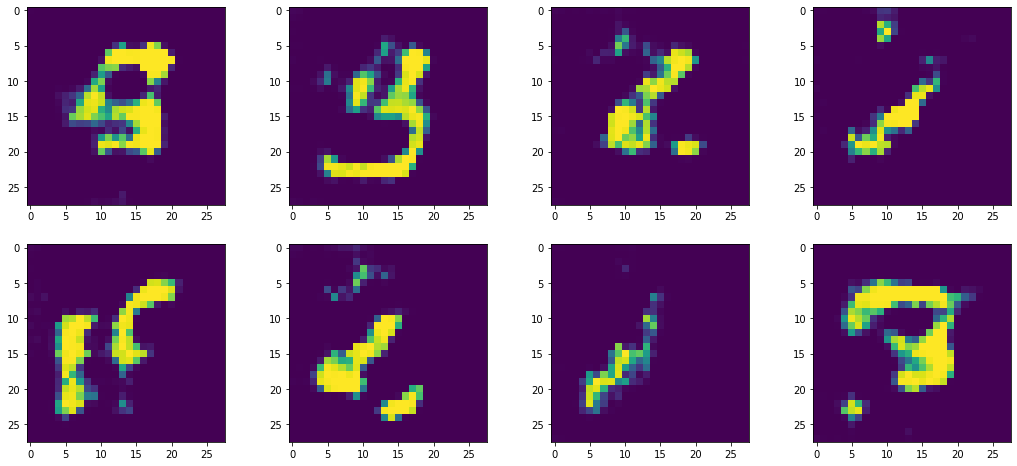

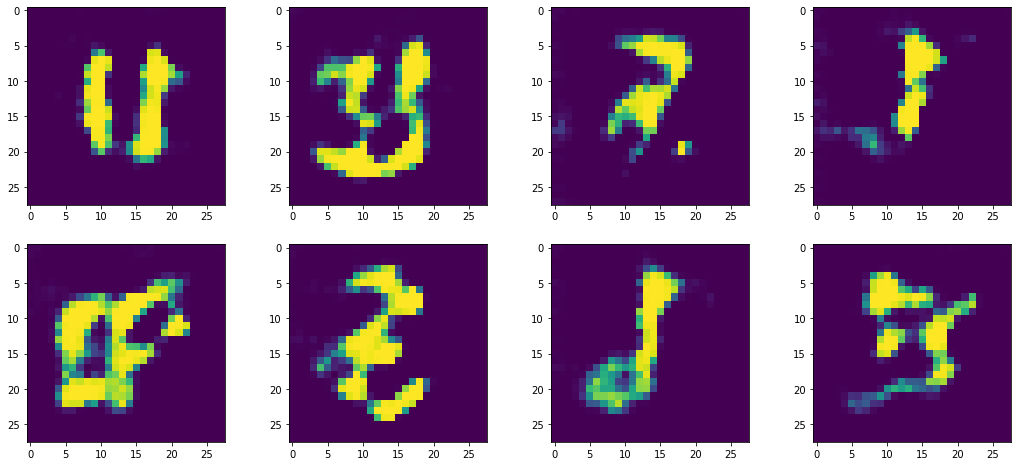

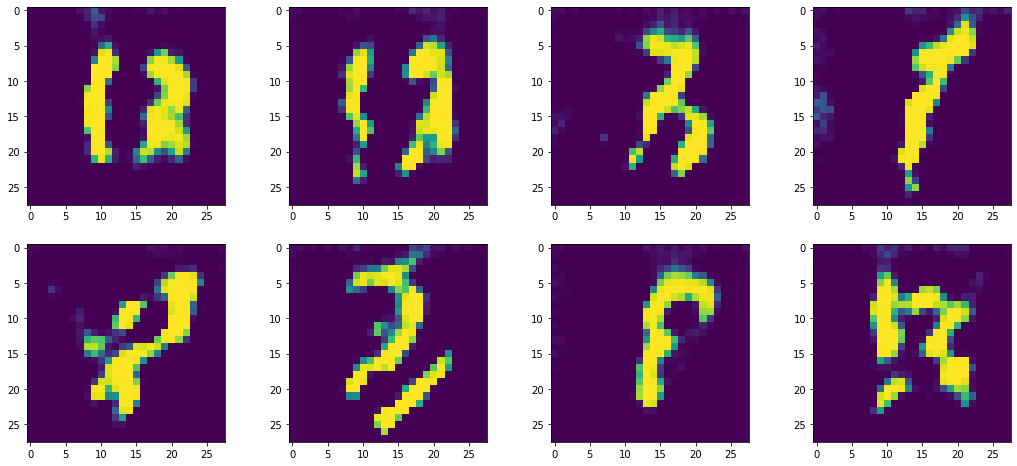

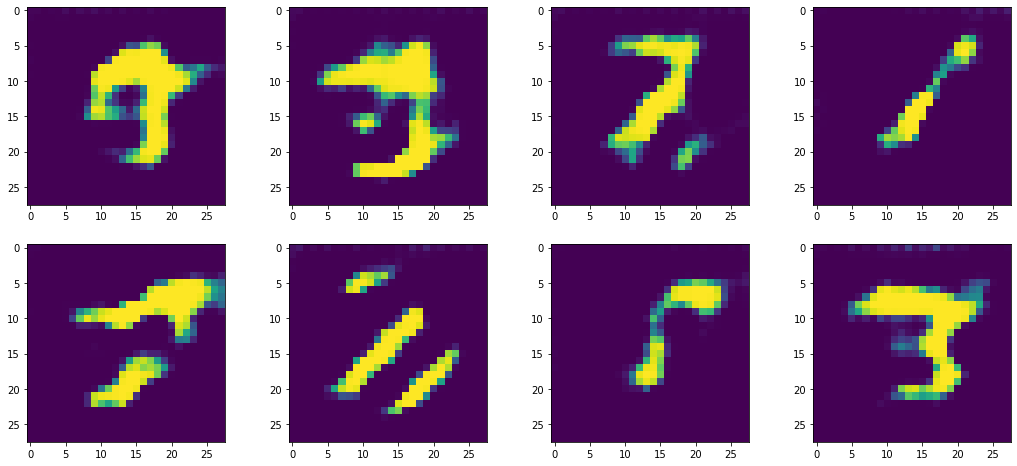

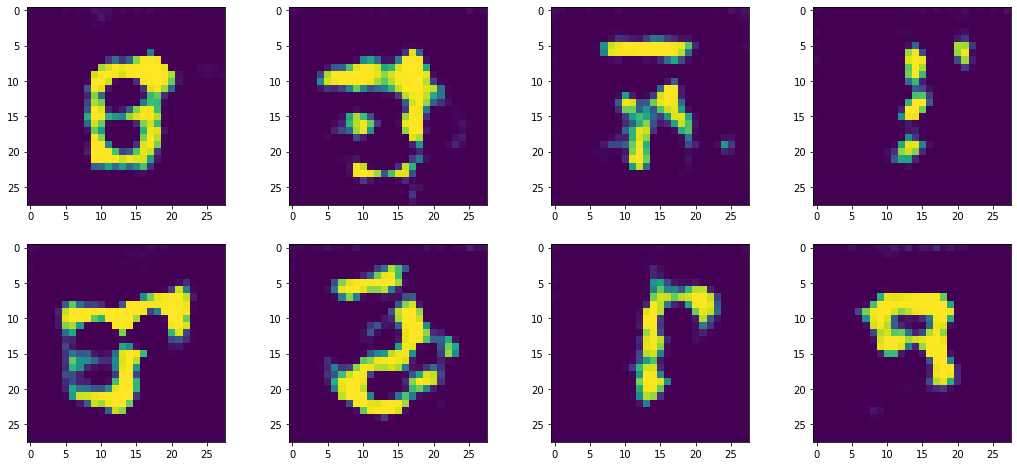

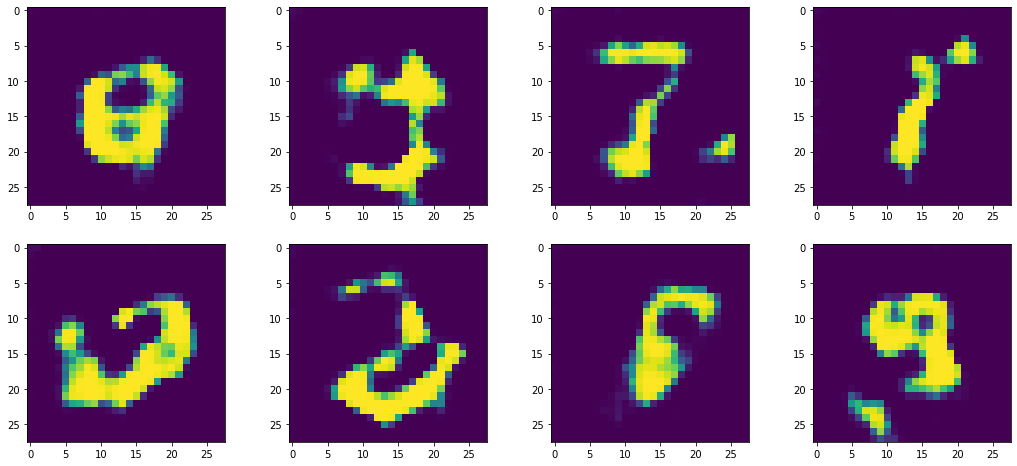

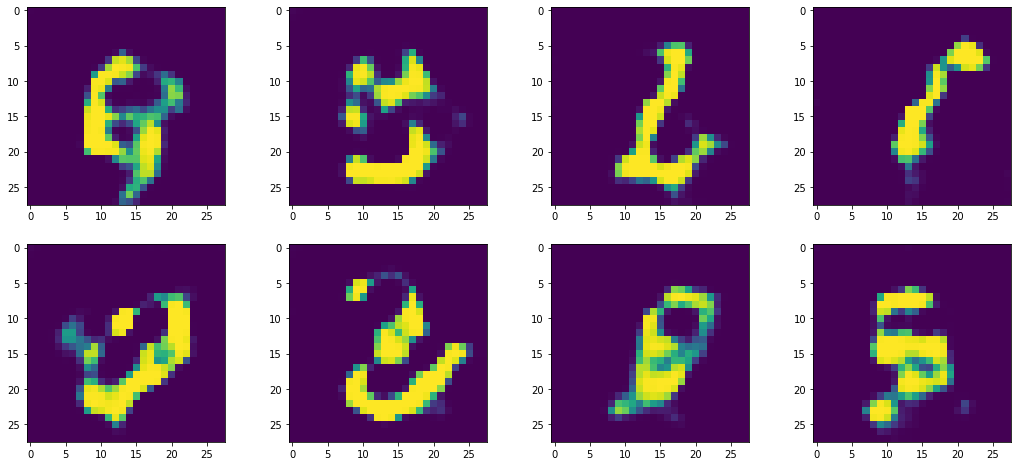

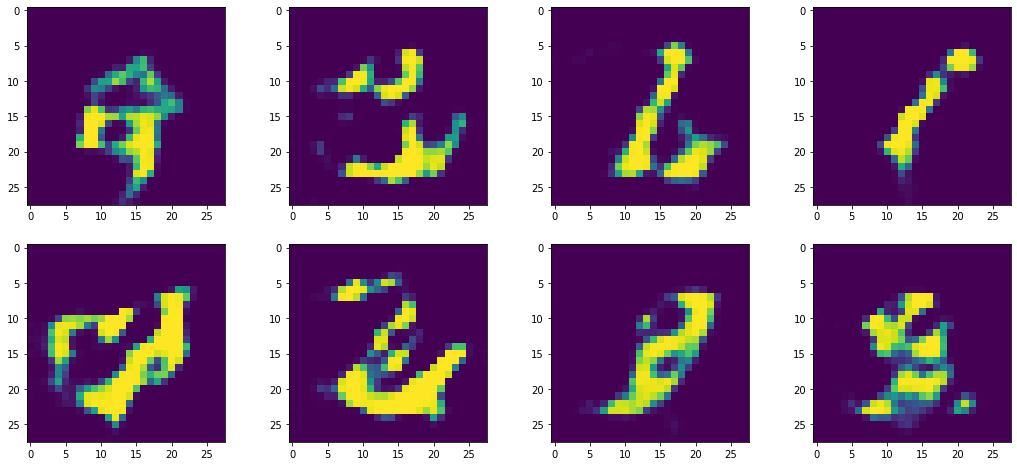

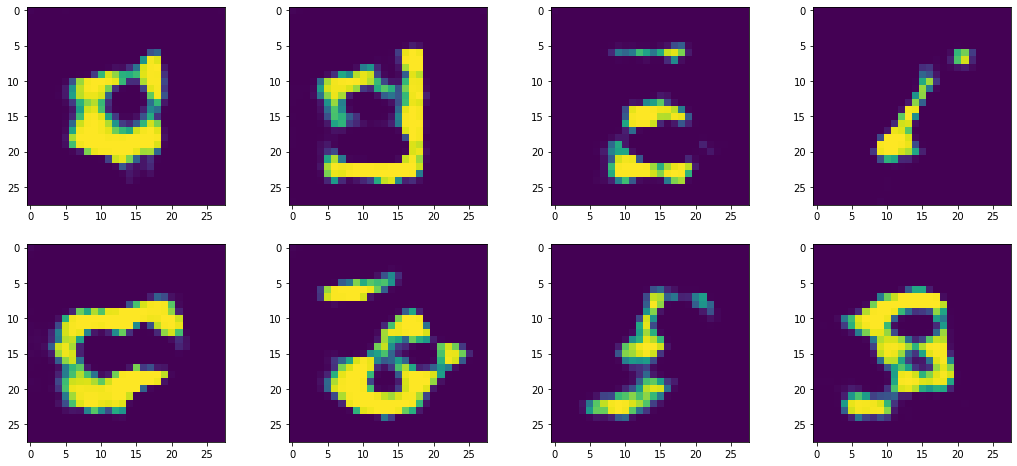

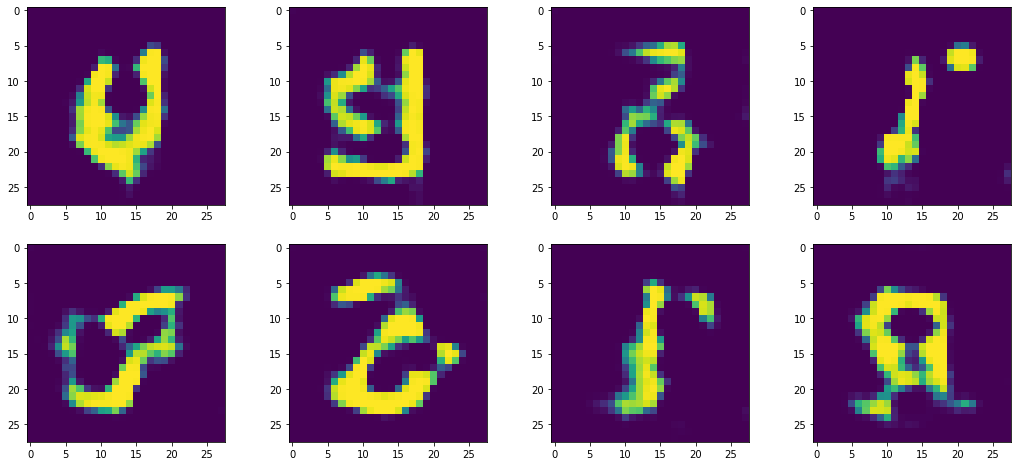

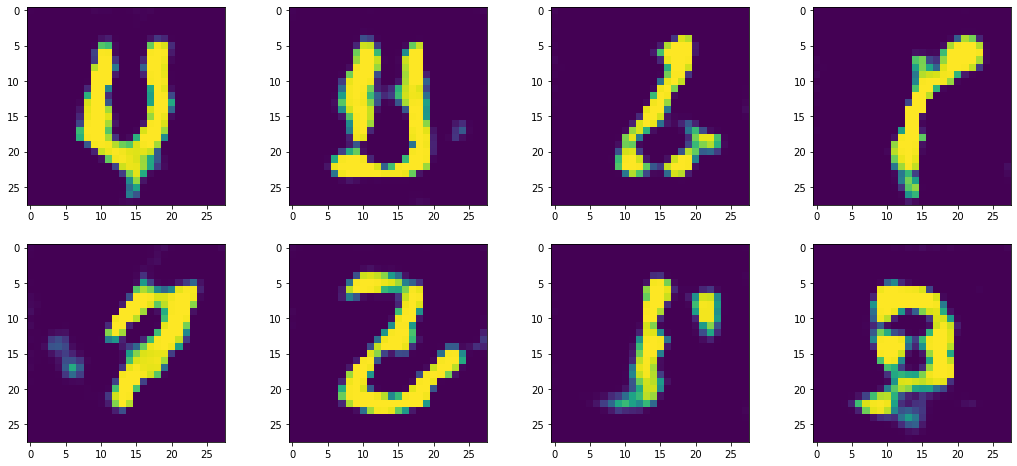

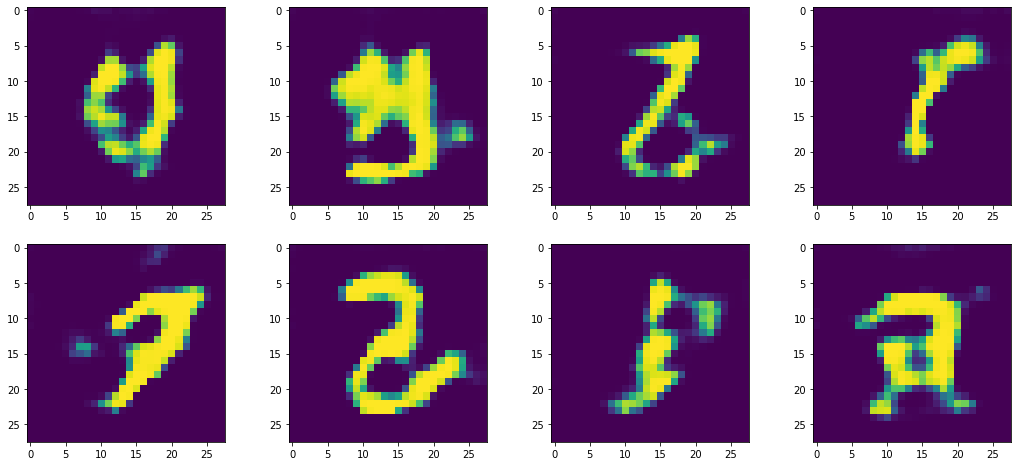

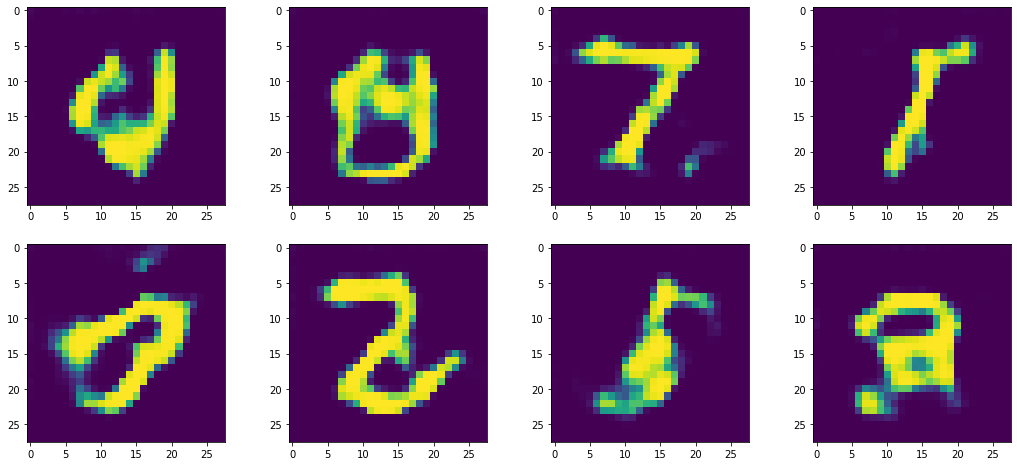

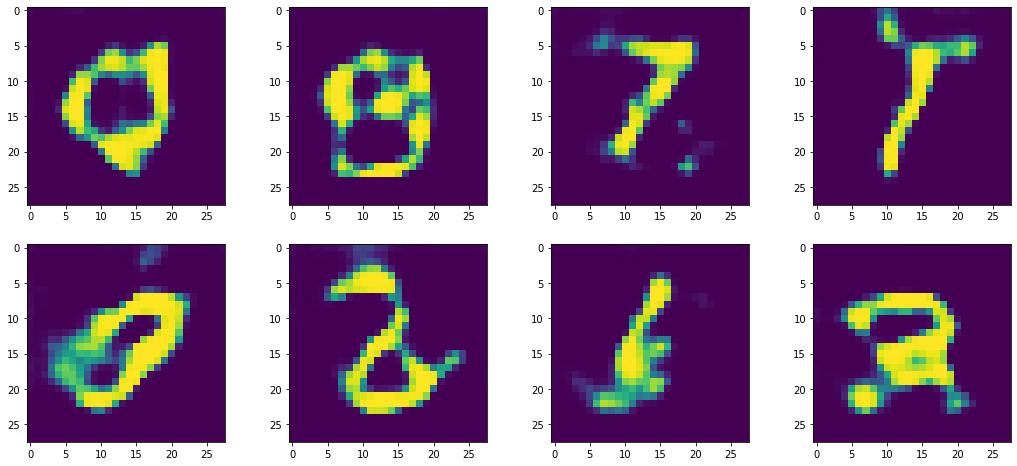

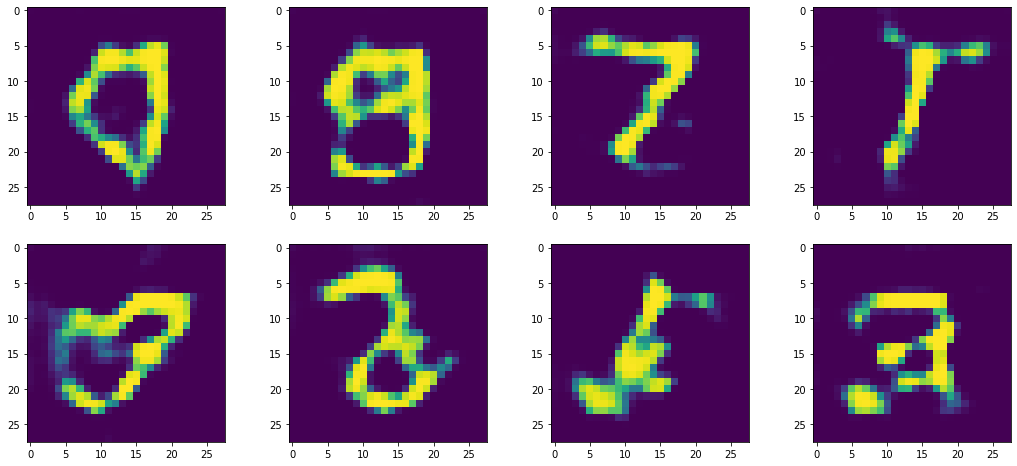

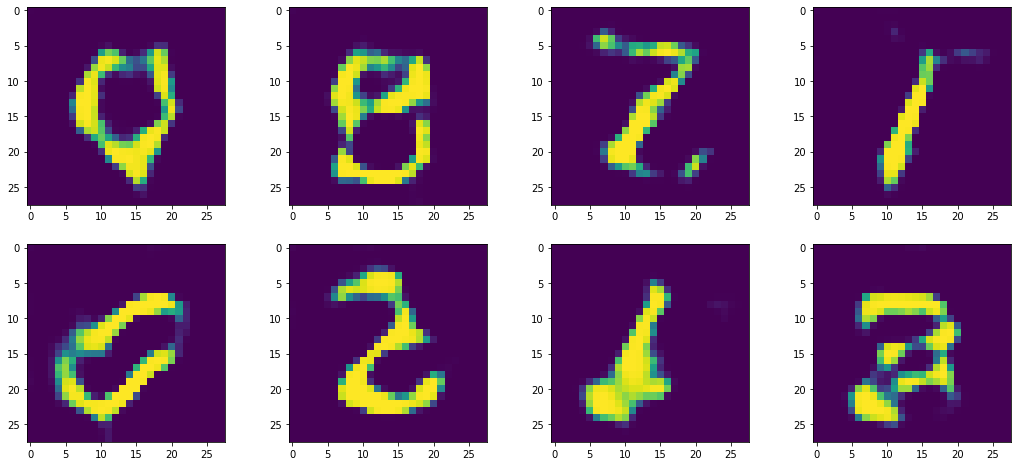

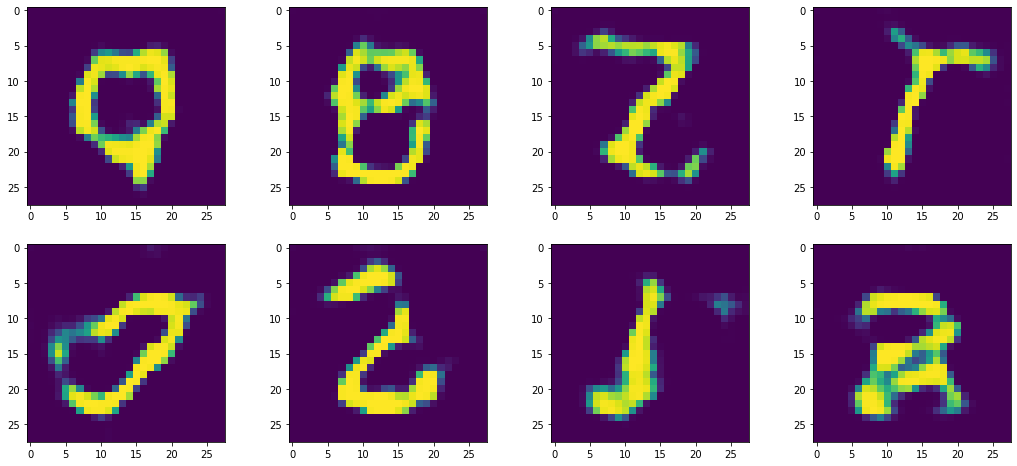

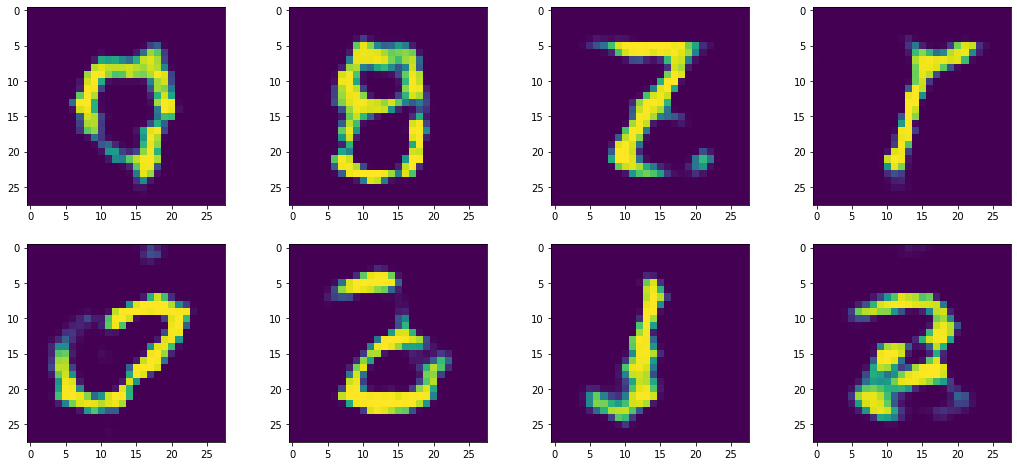

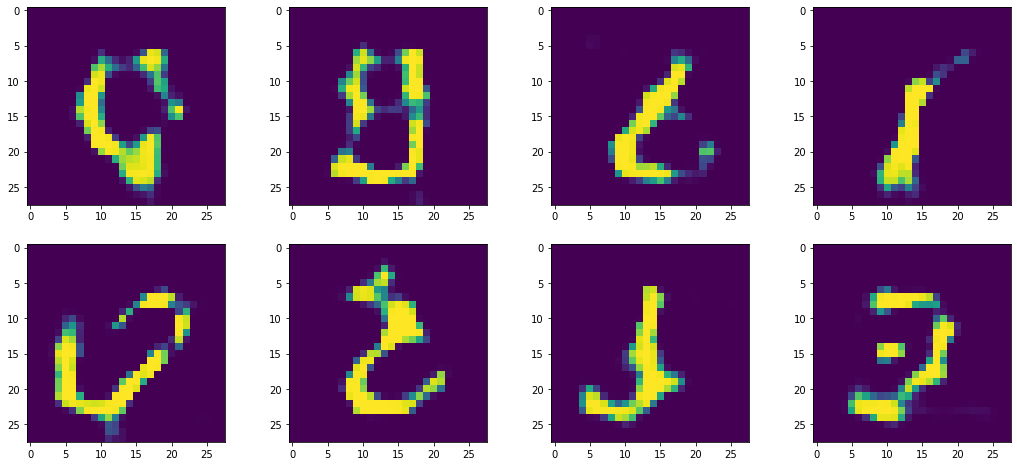

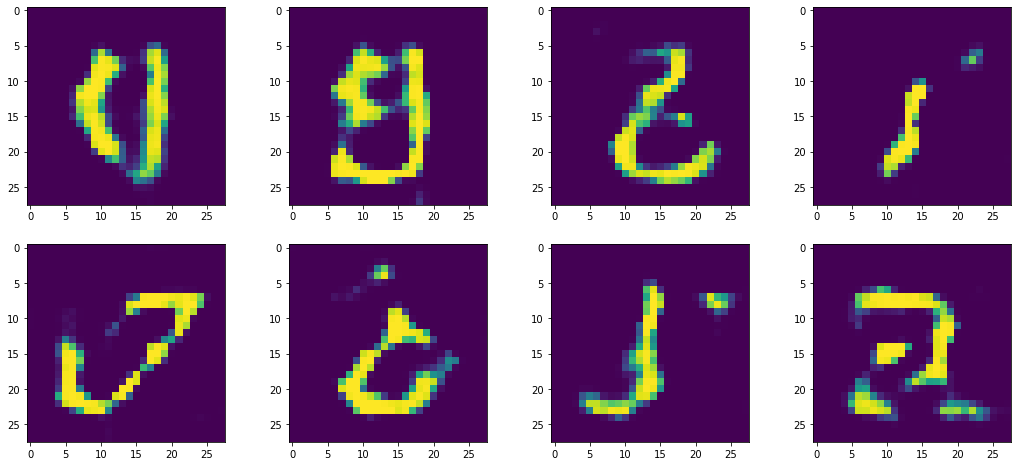

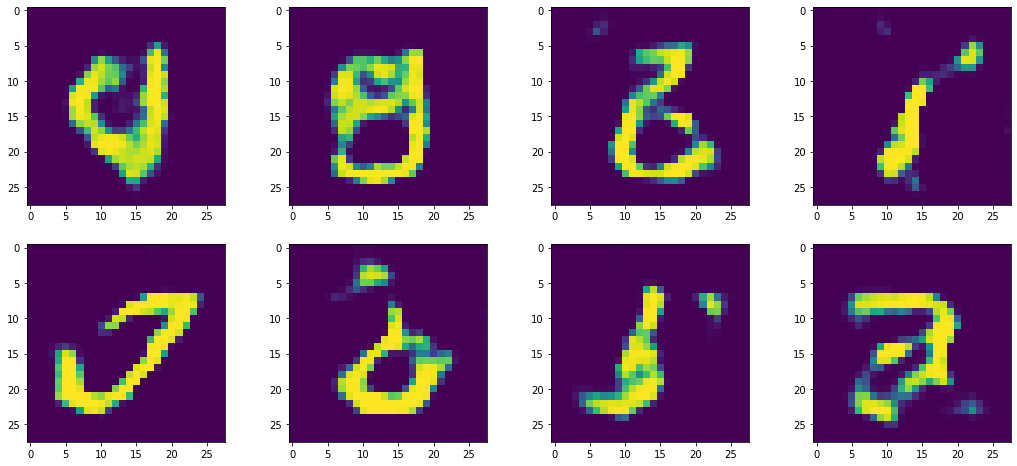

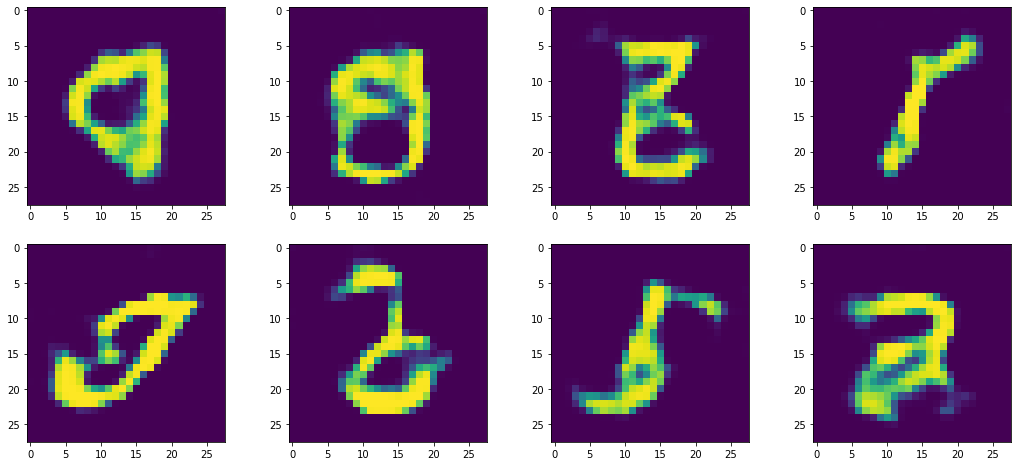

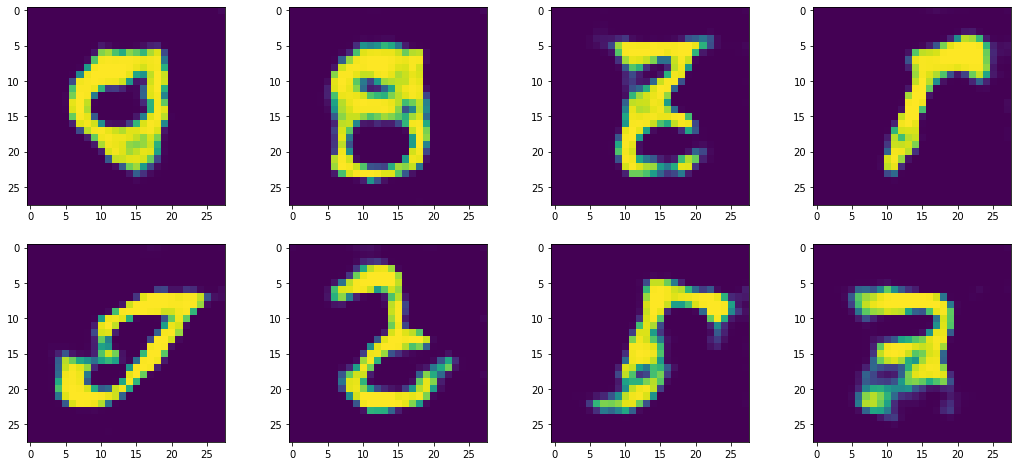

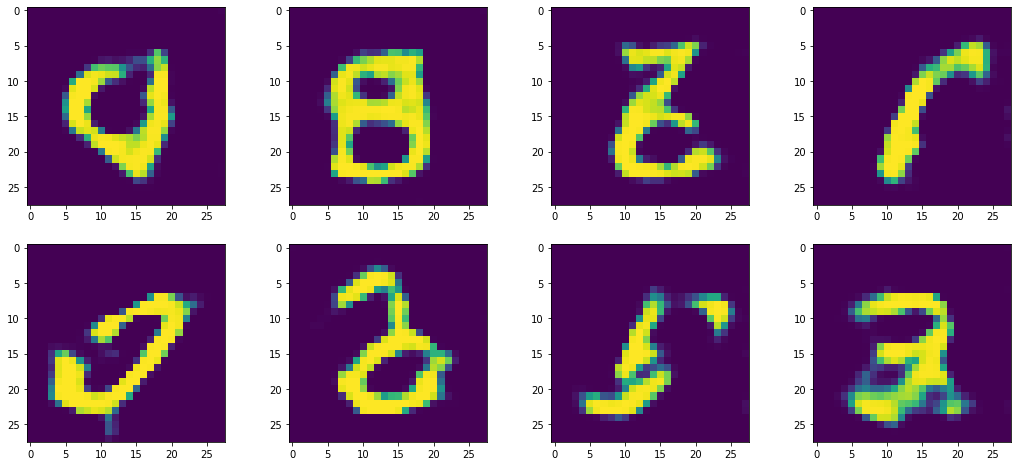

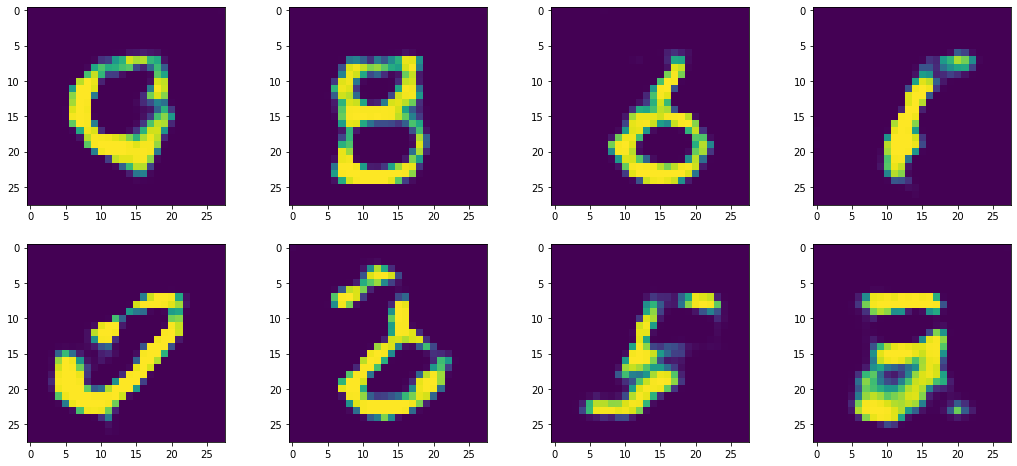

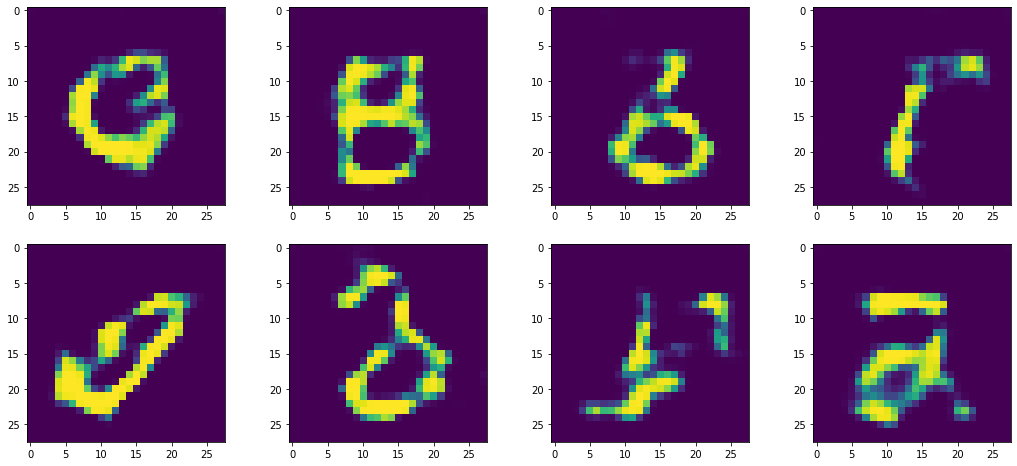

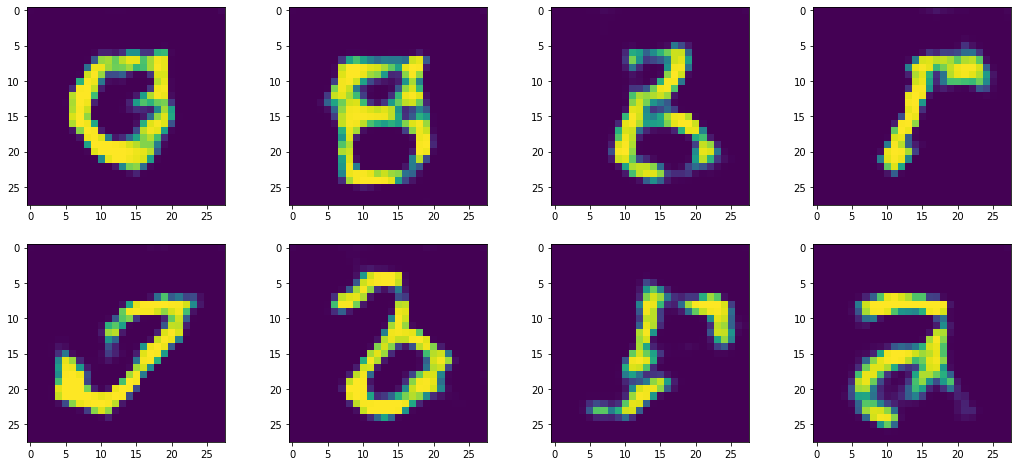

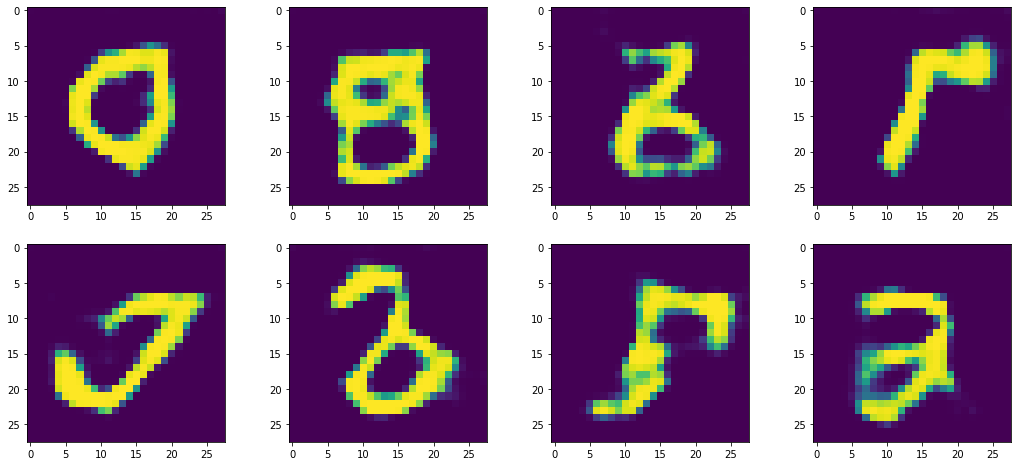

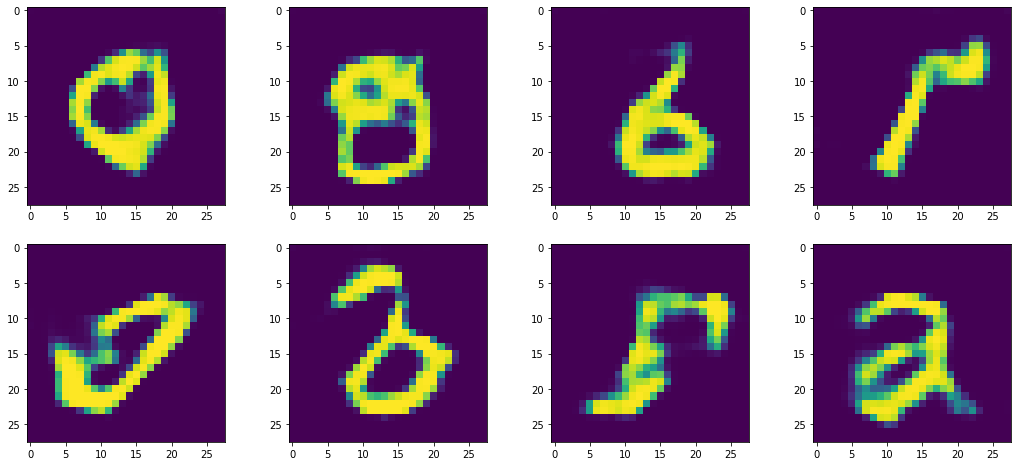

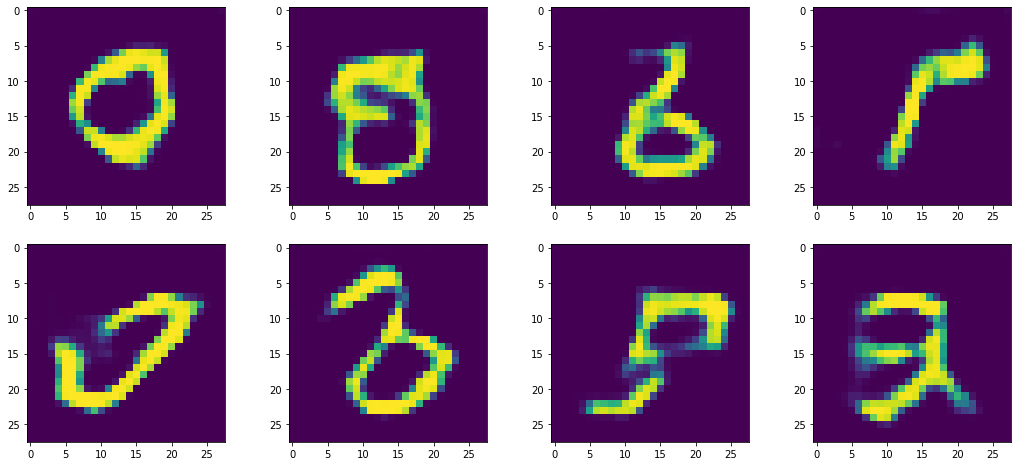

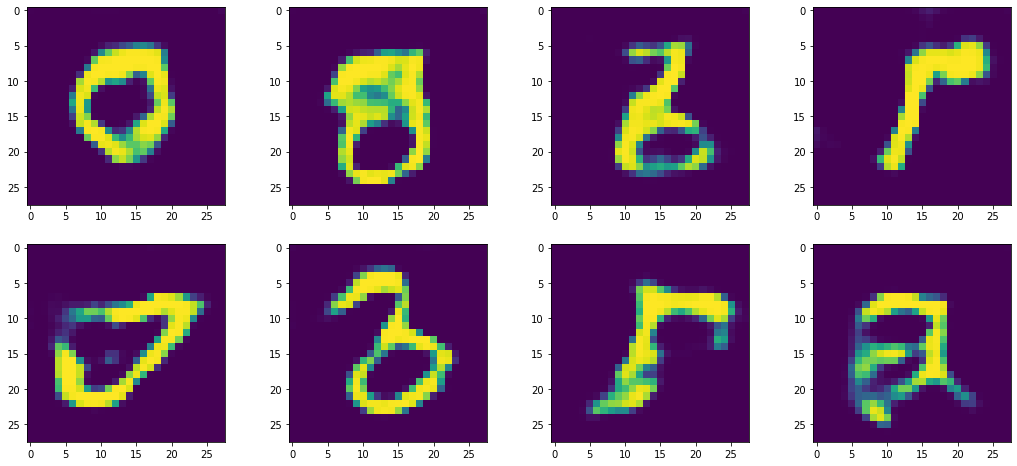

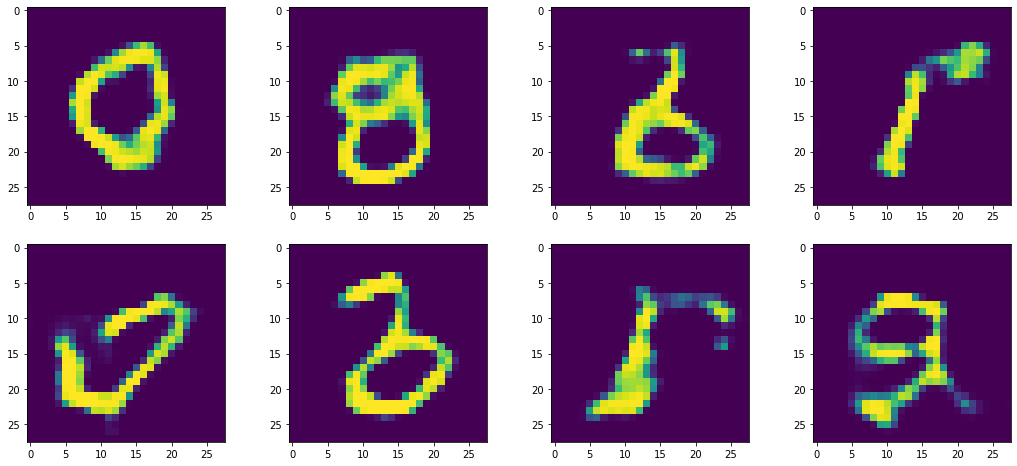

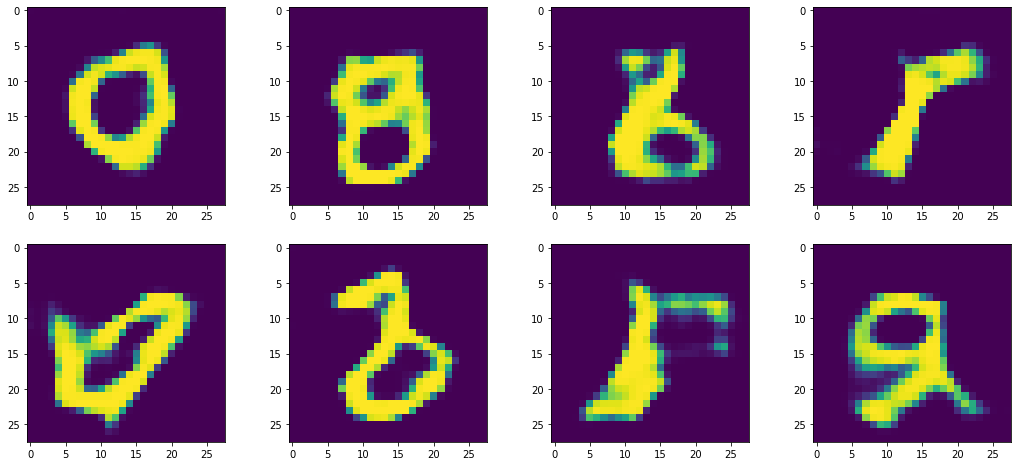

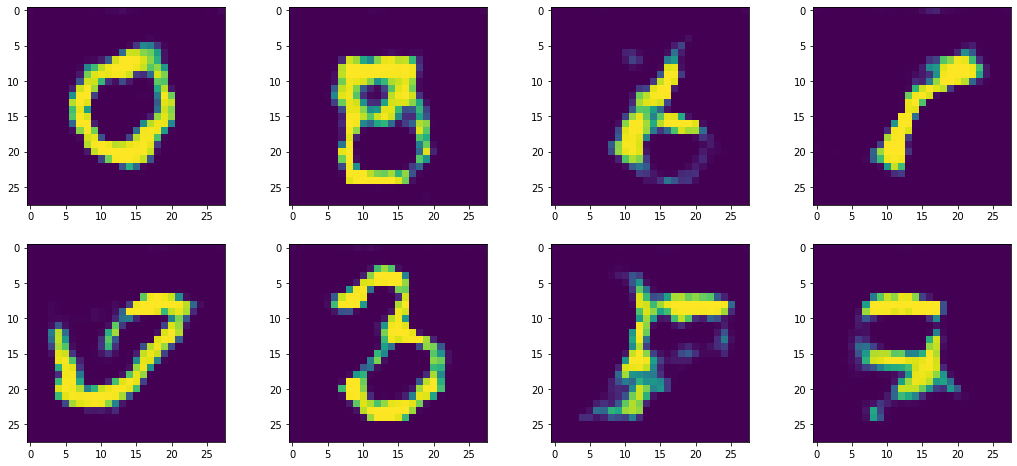

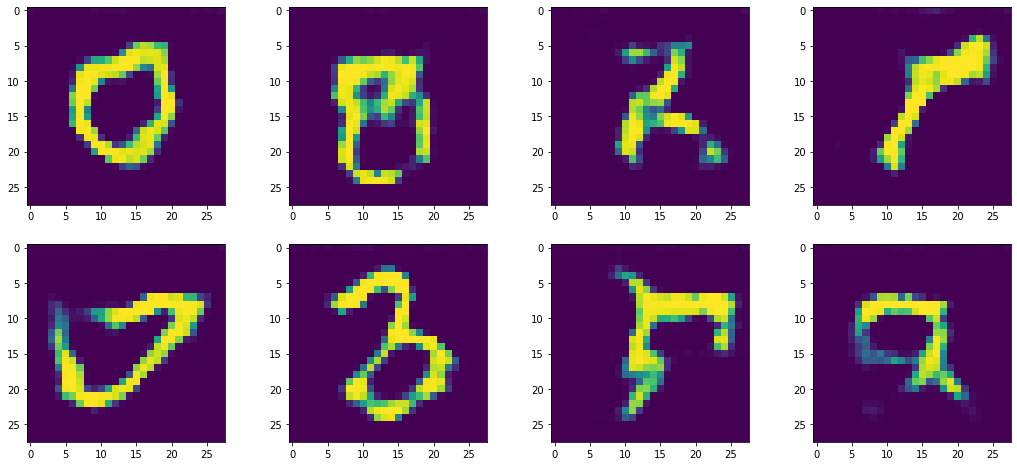

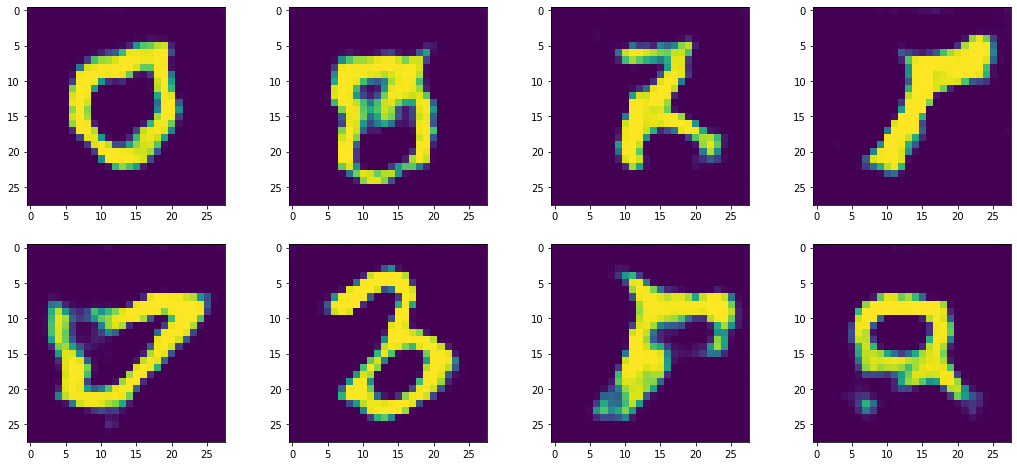

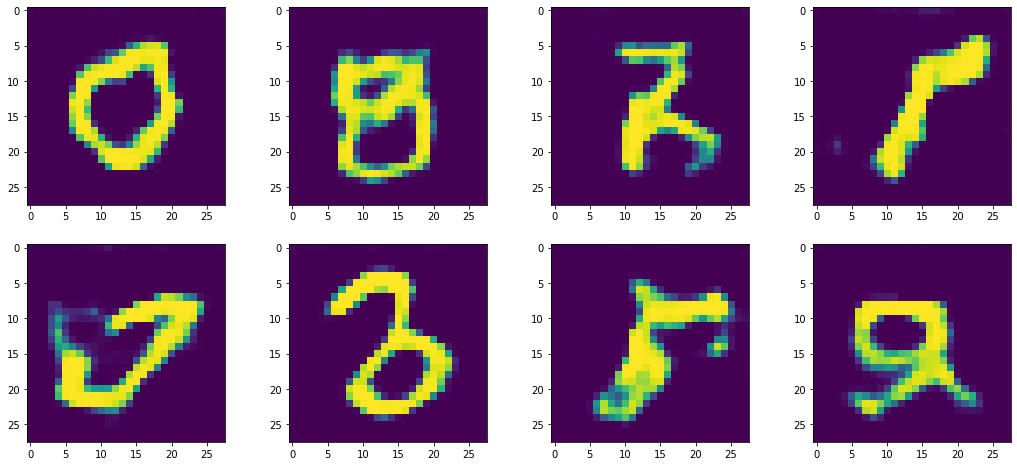

In [95]:
sample_noise = tf.random.normal((8, NOISE_DIM))
play(sample_noise)
for _ in range(50):
    for images in tqdm.tqdm_notebook(dataset, total=len(list(dataset))):
        train_step(images)
    play(sample_noise)

In [98]:
# generator.save('generator.h5')
# discriminator.save('discriminator.h5')